In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import zipfile

# Path to the directory containing the zip file
directory = "/kaggle/input/blindroaddataset"

# List all files in the directory
files_in_directory = os.listdir(directory)
print("Files in directory:", files_in_directory)

# Look for a zip file in the directory
zip_file = None
for file in files_in_directory:
    if file.endswith(".zip"):
        zip_file = os.path.join(directory, file)
        break

if zip_file:
    # Extract the zip file
    directory_to_extract_to = "./"
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
    print("Extraction complete.")
else:
    print("No zip file found in the directory.")


In [ ]:
! unzip /kaggle/input/blindroaddataset

In [2]:
import os
train_images_dir = '/kaggle/input/blindroaddataset/TBRSD/imgs/train'
train_labels_dir = '/kaggle/input/blindroaddataset/TBRSD/labels/train'
test_images_dir = '/kaggle/input/blindroaddataset/TBRSD/imgs/test'
test_labels_dir = '/kaggle/input/blindroaddataset/TBRSD/labels/test'
val_images_dir = '/kaggle/input/blindroaddataset/TBRSD/imgs/val'
val_labels_dir = '/kaggle/input/blindroaddataset/TBRSD/labels/val'

In [3]:
print(len(train_images_dir))  # Check length of images array
print(len(train_labels_dir))

47
49


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


# Function to read and resize images
def read_image(image_path, label_dir, size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, size)
        img = np.expand_dims(img, axis=-1)


        # Extract filename without extension
        filename = os.path.splitext(os.path.basename(image_path))[0]

        # Find corresponding label file
        label_path = os.path.join(label_dir, filename + '.png')  # Assuming label files have .png extension
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, size)
        label = np.expand_dims(label, axis=-1)  # Ensure label has shape (height, width, 1)
    else:
        print(f"Error reading image {image_path}")
        label = None
    return img, label

# Read and resize all images and labels
image_size = (128, 128)
images = []
labels = []

for filename in os.listdir(train_images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(train_images_dir, filename)
        image, label = read_image(image_path, train_labels_dir, image_size)
        if image is not None and label is not None:
            images.append(image)
            labels.append(label)

train_images = np.array(images)
train_labels = np.array(labels)

print(f"Images shape: {train_images.shape}")
print(f"labels shape: {train_labels.shape}")


Images shape: (2500, 128, 128, 1)
labels shape: (2500, 128, 128, 1)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


# Function to read and resize images
def read_image(image_path, label_dir, size):
    img = cv2.imread(image_path)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, size)
        img = np.expand_dims(img, axis=-1)

        # Extract filename without extension
        filename = os.path.splitext(os.path.basename(image_path))[0]

        # Find corresponding label file
        label_path = os.path.join(label_dir, filename + '.png')  # Assuming label files have .png extension
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, size)
        label = np.expand_dims(label, axis=-1)  # Ensure label has shape (height, width, 1)
    else:
        print(f"Error reading image {image_path}")
        label = None
    return img, label

# Read and resize all images and labels
image_size = (128, 128)
images = []
labels = []

for filename in os.listdir(test_images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(test_images_dir, filename)
        image, label = read_image(image_path, test_labels_dir, image_size)
        if image is not None and label is not None:
            images.append(image)
            labels.append(label)

test_images = np.array(images)
test_labels = np.array(labels)

print(f"Images shape: {test_images.shape}")
print(f"labels shape: {test_labels.shape}")

Images shape: (2180, 128, 128, 1)
labels shape: (2180, 128, 128, 1)


In [6]:
image_size = (128, 128)
images = []
labels = []
for filename in os.listdir(val_images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(val_images_dir, filename)
        image, label = read_image(image_path, val_labels_dir, image_size)
        if image is not None and label is not None:
            images.append(image)
            labels.append(label)

val_images = np.array(images)
val_labels = np.array(labels)

print(f"Images shape: {val_images.shape}")
print(f"labels shape: {val_labels.shape}")

Images shape: (500, 128, 128, 1)
labels shape: (500, 128, 128, 1)


In [7]:
import tensorflow as tf
class IoU(tf.keras.metrics.Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true to float32 if not already
        y_true = tf.cast(y_true, tf.float32)
        
        # Cast y_pred to float32 and threshold at 0.5
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        
        # Compute intersection and union
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        
        # Update metrics
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        iou = self.intersection / (self.union + tf.keras.backend.epsilon())
        return iou

    def reset_states(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

2024-08-21 11:53:43.805760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 11:53:43.805869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 11:53:43.934371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import f1_score
import numpy as np

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Dropout(0.2)(conv)  # Adjusted dropout rate
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Instantiate the model
unet_model = Unet((128, 128, 1))

# Optimizer with initial learning rate and power decay
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the custom F1 score metric
unet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(),IoU()])

# Data augmentation for training data
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=45,  # Adjusted rotation range
                     width_shift_range=0.05,  # Adjusted shift range
                     height_shift_range=0.05,  # Adjusted shift range
                     zoom_range=0.1)  # Adjusted zoom range
image_datagen = ImageDataGenerator(**data_gen_args)

# Training data generator for augmented images
augmented_train_generator = image_datagen.flow(train_images, train_labels, batch_size=8)  # Adjusted batch size

# Custom combined generator
def combined_generator(original_generator, augmented_generator):
    while True:
        original_data = next(original_generator)
        augmented_data = next(augmented_generator)

        combined_images = np.concatenate((original_data[0], augmented_data[0]))
        combined_labels = np.concatenate((original_data[1], augmented_data[1]))

        yield combined_images, combined_labels

# Original data generator
original_train_generator = ImageDataGenerator().flow(train_images, train_labels, batch_size=8)

# Create the combined generator
train_generator = combined_generator(original_train_generator, augmented_train_generator)




In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import f1_score
import numpy as np

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Dropout(0.2)(conv)  # Adjusted dropout rate
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Instantiate the model
unet_model = Unet((128, 128, 1))

# Define the initial learning rate and learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile the model with the custom F1 score metric
unet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(),IoU()])

# Data augmentation for training data
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=45,  # Adjusted rotation range
                     width_shift_range=0.05,  # Adjusted shift range
                     height_shift_range=0.05,  # Adjusted shift range
                     zoom_range=0.1)  # Adjusted zoom range
image_datagen = ImageDataGenerator(**data_gen_args)

# Training data generator for augmented images
augmented_train_generator = image_datagen.flow(train_images, train_labels, batch_size=8)  # Adjusted batch size

# Custom combined generator
def combined_generator(original_generator, augmented_generator):
    while True:
        original_data = next(original_generator)
        augmented_data = next(augmented_generator)

        combined_images = np.concatenate((original_data[0], augmented_data[0]))
        combined_labels = np.concatenate((original_data[1], augmented_data[1]))

        yield combined_images, combined_labels

# Original data generator
original_train_generator = ImageDataGenerator().flow(train_images, train_labels, batch_size=8)

# Create the combined generator
train_generator = combined_generator(original_train_generator, augmented_train_generator)




In [9]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0] 

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs")

callbacks = [early_stopping, tensorboard_callback]

# Model training
unet_result = unet_model.fit(
    original_train_generator,
    steps_per_epoch=len(train_images) // 4,  # Adjust batch size accordingly
    validation_data=(val_images, val_labels),
    epochs=200,
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-21 11:54:45.966777: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34444, expected 0.63728
2024-08-21 11:54:45.966830: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.03127, expected 1.32412
2024-08-21 11:54:45.966840: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.75285, expected 1.0457
2024-08-21 11:54:45.966848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.28361, expected 1.57645
2024-08-21 11:54:45.966856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

  2/625 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - f1_score: 0.1412 - iou: 0.0760 - loss: 1.1082   

I0000 00:00:1724241308.005840     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


165/625 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - f1_score: 0.1199 - iou: 0.0638 - loss: 0.6071

2024-08-21 11:55:28.043194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.85568, expected 1.34212
2024-08-21 11:55:28.043248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.57747, expected 2.06391
2024-08-21 11:55:28.043257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.6576, expected 2.14404
2024-08-21 11:55:28.043265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.44992, expected 1.93635
2024-08-21 11:55:28.043273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.20246, expected 1.68889
2024-08-21 11:55:28.043281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.06714, expected 1.55357
2024-08-21 11:55:28.043288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.2609, expected 1.74733
2024-08-21 11:55:28.043296: E external/local_xla/xla/serv

313/625 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - f1_score: 0.1039 - iou: 0.0549 - loss: 0.4991

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-21 11:55:58.891855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.99935, expected 1.15449
2024-08-21 11:55:58.891925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.95442, expected 2.10956
2024-08-21 11:55:58.891941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.94738, expected 2.10252
2024-08-21 11:55:58.891960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.64443, expected 1.79958
2024-08-21 11:55:58.891976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.30141, expected 1.45655
2024

625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 118ms/step - f1_score: 0.1012 - iou: 0.0533 - loss: 0.4224 - val_f1_score: 0.1013 - val_iou: 0.0533 - val_loss: 0.2375
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - f1_score: 0.4925 - iou: 0.3278 - loss: 0.2018 - val_f1_score: 0.5760 - val_iou: 0.4045 - val_loss: 0.1863
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - f1_score: 0.6250 - iou: 0.4546 - loss: 0.1527 - val_f1_score: 0.6273 - val_iou: 0.4570 - val_loss: 0.1467
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - f1_score: 0.6766 - iou: 0.5113 - loss: 0.1279 - val_f1_score: 0.5929 - val_iou: 0.4213 - val_loss: 0.1398
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - f1_score: 0.7059 - iou: 0.5457 - loss: 0.1122 - val_f1_score: 0.6277 - val_iou: 0.4575 - val_loss: 0.1202
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - f1_score: 0.7379 - iou: 0.5847 - loss: 0.0980 - val_f1_score: 0.7039 - val_iou: 0.5431 - val_loss: 0.1027
Epoch 7/200
625/625 ━━━━━━━━━━━━

In [12]:
test_loss, test_f1_score, test_iou = unet_model.evaluate(test_images, test_labels, verbose=1)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1_score}")
print(f"Test IoU: {test_iou}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - f1_score: 0.8963 - iou: 0.8121 - loss: 0.1193
Test Loss: 0.12325435131788254
Test F1 Score: 0.8927579522132874
Test IoU: 0.806289792060852


In [13]:
# Generate predictions on the test set
predictions = unet_model.predict(test_images)

# Apply thresholding to convert predictions to binary mask
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step


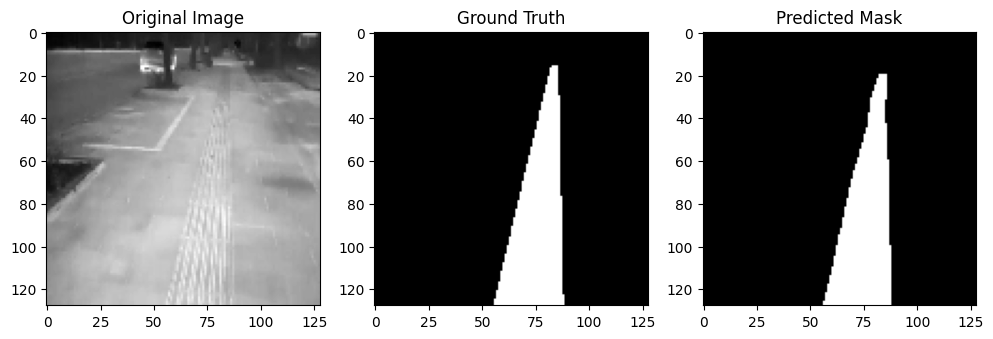

In [14]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_prediction(index):
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[index].squeeze(), cmap='gray')
    plt.title('Original Image')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(test_labels[index].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[index].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()

# Visualize the first prediction
visualize_prediction(0)

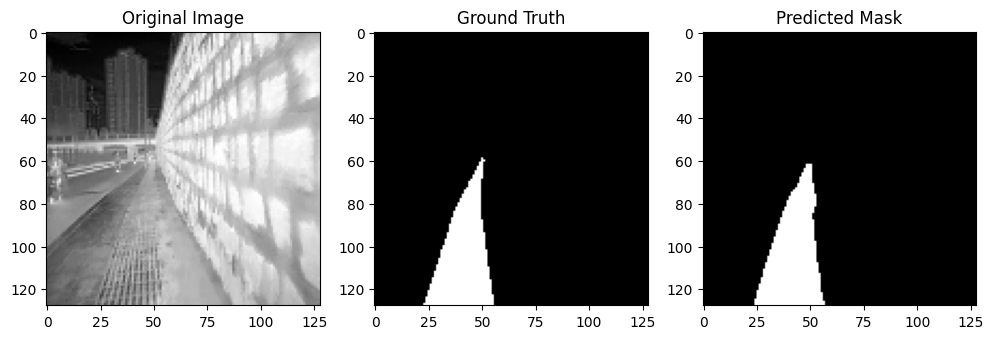

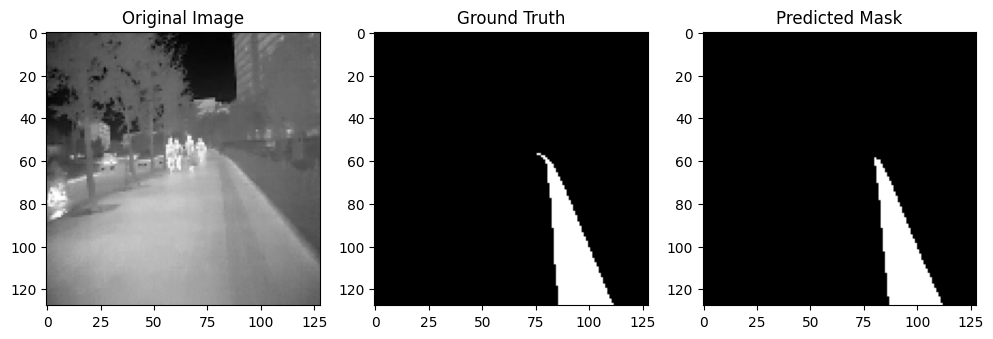

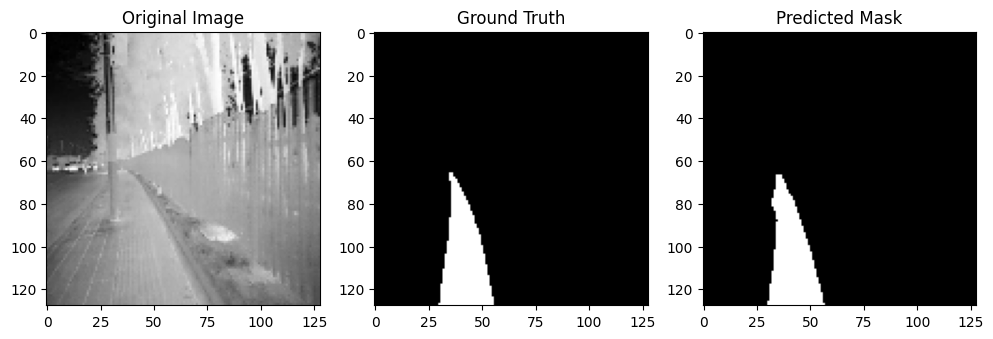

In [18]:
visualize_prediction(5)
visualize_prediction(41)
visualize_prediction(30)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard


# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = TensorBoard(log_dir='./logs')

callbacks = [early_stopping, reduce_lr, tensorboard_callback]

# Model training
unet_result = unet_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 8,  # Adjust batch size accordingly
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=callbacks
)
